# Mie scattering from PMDI droplets

This program estimates light scattering from spherical droplets to approximate optical PMDI experiments.
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2020 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 06/05/2020
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia


In [30]:
# Load modules
import numpy as np
import scipy.special 
import scipy.integrate
import scipy.signal
import matplotlib.pyplot as plt
import sys
from joblib import Parallel, delayed
%matplotlib notebook


## Absorption and Scattering of Light by Small Particles
(Book by Craig Bohren and Donald Huffman)

Ch6. SCATTERING BY AN ISOTROPIC, HOMOGENEOUS SPHERE.

Calculate the forward-scattering extinction coefficient for a uniform dielectric sphere.

The Riccatti-Bessel functions $\psi_n(x)$ and $\xi_n(x)$ are defined on the following sites:

- https://en.wikipedia.org/wiki/Bessel_function#Riccati–Bessel_functions:_Sn,_Cn,_ξn,_ζn
- https://docs.scipy.org/doc/scipy/reference/special.html
- https://www.boost.org/doc/libs/1_57_0/libs/math/doc/html/math_toolkit/bessel/bessel_derivatives.html


In [50]:
# Mie coefficients a_n, b_n
# n is the summation series index
# m is complex refractive index
# x is the size parameter
# rbvals are Ricatti-Bessel functions pre-evaluated.
def mie_coeffs(n, m, x, rbvals):
    
    psi_n, xi__n, dpsi_m, psi_m = rbvals
    
    # Logarithmic derivative (d/dx)ln(Psi_n(m*x))
    # using chain rule, this is Psi'_n(m*x)/Psi_n(m*x)
    logderiv = dpsi_m[n]/complex(psi_m[n]+1e-99)
    
    # Evaluate A
    A = ((logderiv/complex(m)) + (n/complex(x)))
    a_numr = A*psi_n[n] - psi_n[n-1] #A*ricattiBesselPsi(x,n) - ricattiBesselPsi(x,n-1)
    a_deno = A*xi__n[n] - xi__n[n-1] #A*ricattiBesselXi(x,n) - ricattiBesselXi(x,n-1)
    a_deno += 1e-99
    
    # Evaluate B
    B = ((m*logderiv/complex(m)) + (n/complex(x)))
    b_numr = B*psi_n[n] - psi_n[n-1] #B*ricattiBesselPsi(x,n) - ricattiBesselPsi(x,n-1)
    b_deno = B*xi__n[n] - xi__n[n-1] #B*ricattiBesselXi(x,n) - ricattiBesselXi(x,n-1)
    b_deno += 1e-99
    
    return a_numr/a_deno, b_numr/b_deno


# Extinction & Scattering cross sections
# r is the radius of the scattering sphere.
# k is the wavenumber of incident light
# m is complex refractive index of the sphere relative to the surroundings
def CrossSections(k,m,r):

    # Enforce a complex refractive index for type matching
    m = complex(m)
    
    # Size parameter
    x = k*r
    
    # n_max from BHMIE. Too large n_max can cause unacceptable round-off error!
    n_max = int(np.floor(x + 4*(x**0.3333) + 2))
    if n_max < 1: n_max=1
    
    # Calculate Riccati-Bessel functions Psi & Xi up to n_max
    # See:
    # https://en.wikipedia.org/wiki/Bessel_function#Riccati–Bessel_functions:_Sn,_Cn,_ξn,_ζn
    # https://docs.scipy.org/doc/scipy/reference/special.html
    # https://www.boost.org/doc/libs/1_57_0/libs/math/doc/html/math_toolkit/bessel/bessel_derivatives.html
    import scipy.special

    # Psi_n(x) = x * j_n(x)
    psi_n = [ x*scipy.special.jv(n, x) for n in np.arange(n_max+1) ]
    
    # Xi_n(x) = x * h^1_n(x)
    xi__n = [ x*scipy.special.hankel1(n, x) for n in np.arange(n_max+1) ]
    
    # Psi_n(m*x) = m*x * j_n(m*x)
    psi_m = [ m*x*scipy.special.jv(n, m*x) for n in np.arange(n_max+1) ]
    
    # dPsi_n(m*x) = (d/dx) Psi_n(m*x) = (d/dx)(mx*j_n(mx)) = ( m^2 * x * dj_n(m*x) m*j_n(mx))
    # where derivative dj_n(x) = (n/x)*jv_n(x) - jv_{n-1}(x)
    def jv_deriv(n,z): 
        return (n/z)*scipy.special.jv(n, x) - scipy.special.jv(n-1, x)
    dpsi_m = [ (m**2)*x*jv_deriv(n, m*x) + m*scipy.special.jv(n, m*x) for n in np.arange(n_max+1) ]
    
    rbvals = (psi_n, xi__n, dpsi_m, psi_m)
    
    # Summation series
    s_ext = 0
    s_sca = 0
    
    for n in np.arange(1,n_max+1):
        an, bn = mie_coeffs(n,m,x,rbvals)
        s_ext += (2*n+1)*np.real(an + bn)
        s_sca += (2*n+1)*(np.abs(an)**2 + np.abs(bn)**2)
    
        
    # Multiply by the coefficient outside the summation    
    s_ext *= 2 * np.pi / (k**2 + 1e-99)
    s_sca *= 2 * np.pi / (k**2 + 1e-99)
    
    return np.abs(s_ext), np.abs(s_sca)


# Rayleigh scattering cross section - proportional only
def Rayleigh(k,m,r):
    lam=2*np.pi/float(k)
    return (2*(np.pi**5)*((2*r)**6)/(3*lam**4))*np.abs((m**2 - 1)/(m**2 + 2))**2



lambda = 450 nm, m = 0.340269 + 3.3e-10 i


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 1222 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 1702 tasks      | elapsed:    1.4s


lambda = 550 nm, m = 0.335322 + 2.47e-09 i


[Parallel(n_jobs=16)]: Done 2000 out of 2000 | elapsed:    3.6s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1222 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 1702 tasks      | elapsed:    1.1s
[Parallel(n_jobs=16)]: Done 2000 out of 2000 | elapsed:    3.3s finished


<IPython.core.display.Javascript object>


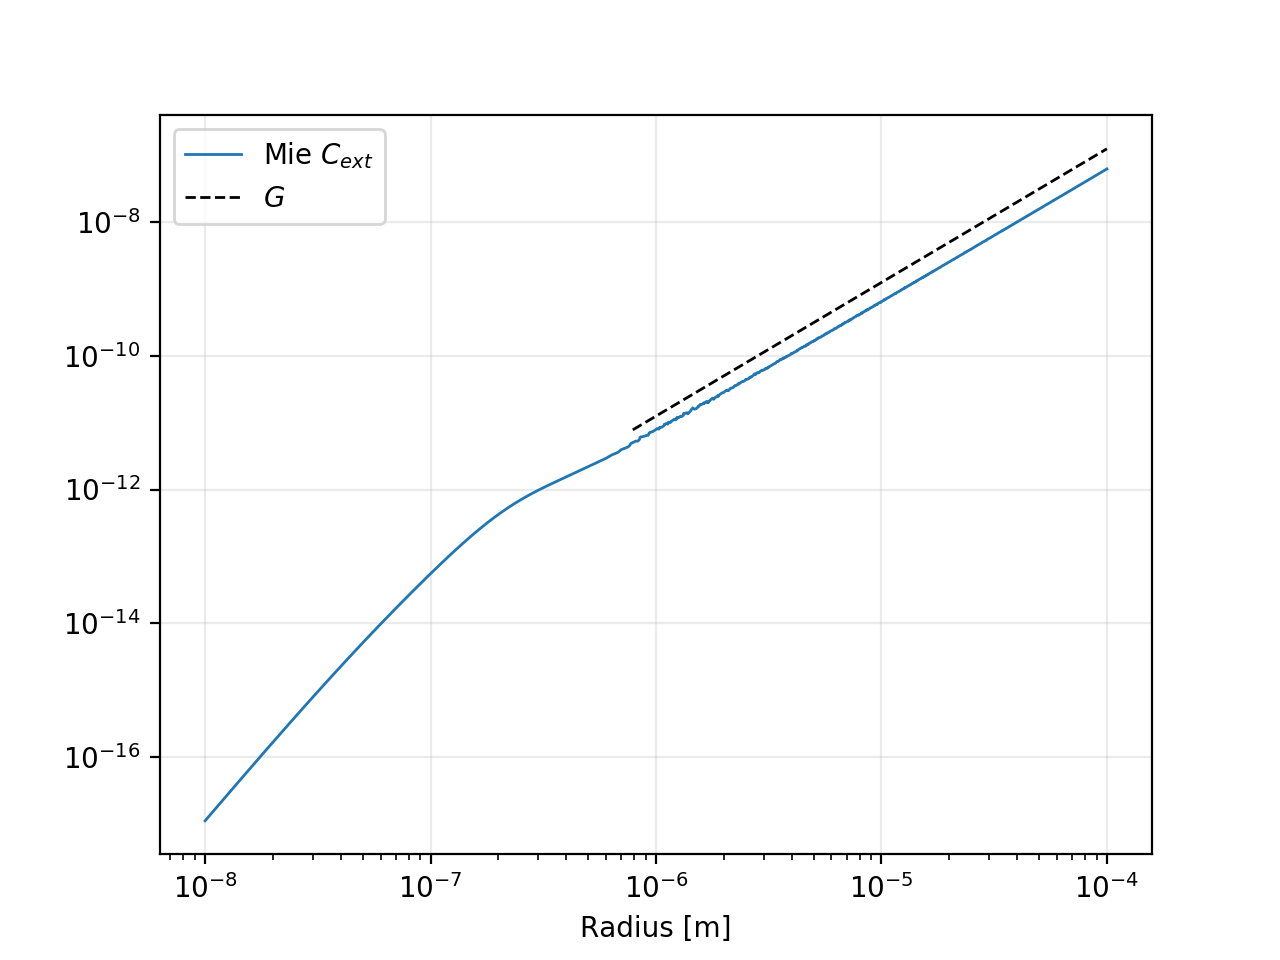

In [52]:
# testing - constants
lam    = np.array([450.0e-9         , 550.0e-9])
m_air  = np.array([1.00028053+0j    , 1.00027784+0j])
m      = np.array([1.34055+3.30e-10j, 1.33560 + 2.47e-09j])  # water in air at 450 & 550nm
radii  = np.logspace(-8,-4,2000)
n_tasks = 16

m -= m_air # difference in refractive index
k = 2*np.pi/lam
x_med = np.median(k)*radii


# result is shape [n_max,2] with C_ext and C_scatt. in each column.
# Repeat for each wavelength of light.
results = []
for i in range(len(lam)):
    print("lambda = %g nm, m = %g + %g i" % (lam[i]*1e9, m[i].real, m[i].imag))
    sys.stdout.flush()
    result = Parallel(n_jobs=n_tasks,verbose=5,batch_size=32)(delayed(CrossSections)(k[i],m[i],r) for r in radii)
    #result = [ CrossSections(k[i],m[i],r) for r in radii ]
    results.append(np.array(result))
results = np.dstack(results)

# Average over wavelengths
result = np.mean(np.nan_to_num(results),axis=2)
result[result<=0] = np.nan

'''
# Smoothing
wl=3
window = scipy.signal.gaussian(wl,wl/6.)
window /= scipy.integrate.simps(window)
for i in range(2):
    result[:,i] = np.convolve(result[:,i], window, 'same')
'''

# Geometric cross section
G = 4*np.pi*radii**2

# plot
fig=plt.figure()
ax=fig.add_subplot(111)
plt.xlabel('Radius [m]')
plt.grid(alpha=.25)

ax.plot(radii, result[:,0], label=r'Mie $C_{ext}$', lw=1)
ax.plot(radii[x_med>=10], G[x_med>=10], label=r'$G$',lw=1,c='k',ls='--')
#ax.plot(radii[x_med<1], Rayleigh(np.mean(k),np.mean(m),radii[x_med<1]),ls='--',lw=1,label='Rayleigh Scatter')

plt.yscale('log')
plt.xscale('log')

plt.legend()
plt.show()

<IPython.core.display.Javascript object>


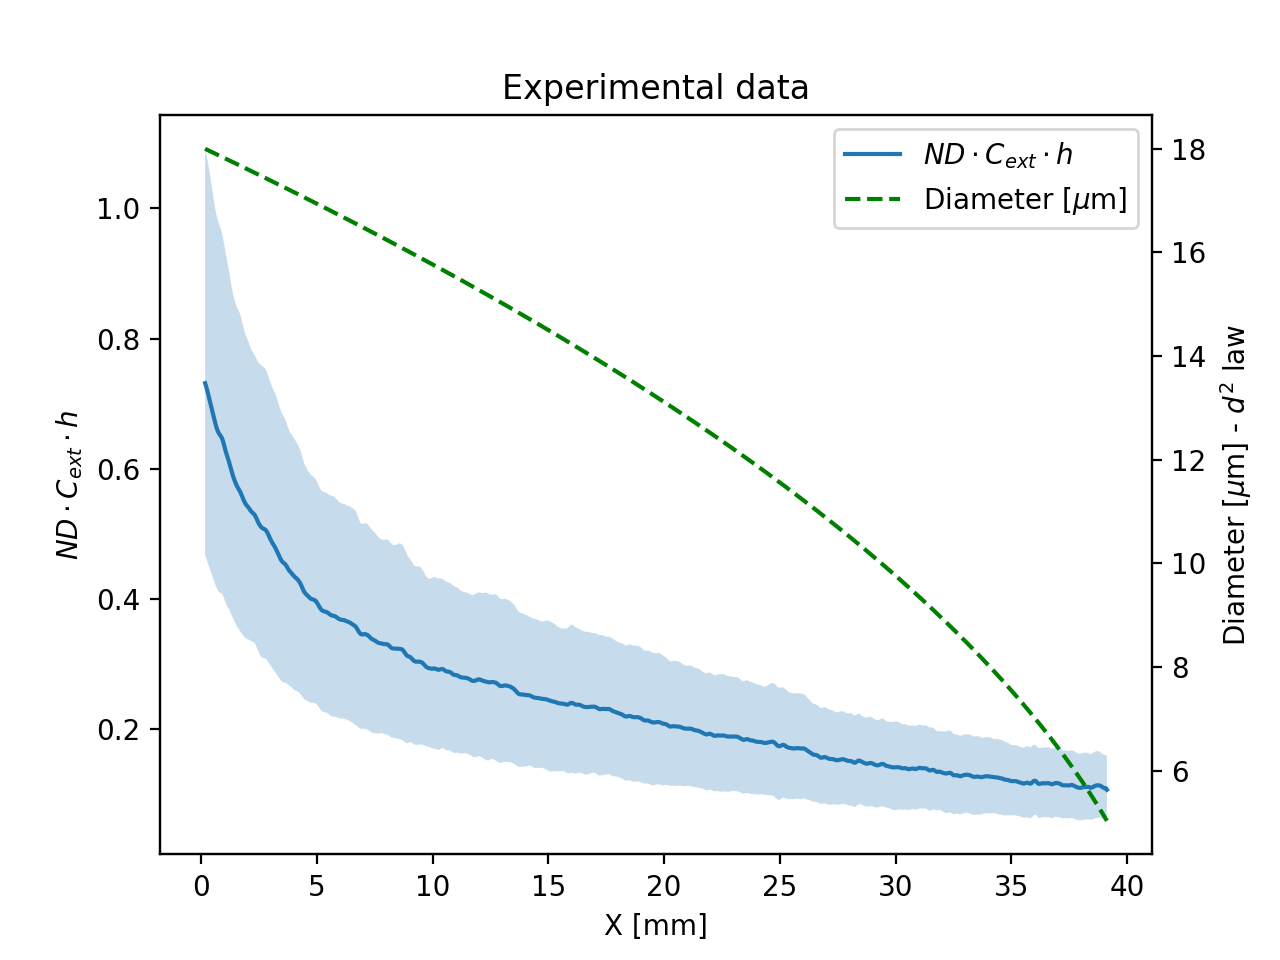

In [57]:
# Load experimental extinction data set
with np.load("ThinBo-1Hole-E05 Example Series centerline profiles.npz") as loaddata:
    experiment = loaddata['arr_0']
# experiment[0,:] = extinction coefficient
# experiment[1,:] = std dev of extinction coeff.

# Set range of streamwise positions to consider
x0 = 4
x1 = experiment.shape[1] - 2

# Here apply spatial resolution to X scale
pixel_per_mm = 1000/42.857 # as indicated from Dung
x_expt = np.arange(x0,x1) / pixel_per_mm

# Calculate number-density*C_ext*sample-thickness
# and std deviation
NCh_expt = -np.log(1.0 - experiment[0,x0:x1])
NCh_err = experiment[1,x0:x1]/experiment[0,x0:x1]
NCh_err1 = -np.log(1.0 - experiment[0,x0:x1] + experiment[1,x0:x1])
NCh_err2 = -np.log(1.0 - experiment[0,x0:x1] - experiment[1,x0:x1])

fig=plt.figure()
ax=fig.add_subplot(111)
plt.title("Experimental data")
plt.ylabel(r"$ND \cdot C_{ext} \cdot h$")
plt.xlabel("X [mm]")
ph0,=ax.plot(x_expt,NCh_expt)
ax.fill_between(x_expt,NCh_err1,NCh_err2,alpha=.25)

# Let's now develop a guess for the droplet size using d-squared law evaporation.
d0 = 18e-6
d1 = 5e-6 #0.8e-6
x0 = float(x0)/pixel_per_mm
x1 = float(x1)/pixel_per_mm

# let d^2 = a*x + b
#     d0^2 - d1^2 = a*(x0-x1)
#      a = (d0^2 - d1^2)/(x0-x1)
d2a = (d0**2 - d1**2)/(x0-x1)
d2b = d0**2 - d2a*x0
d_guess = np.sqrt(d2a*x_expt + d2b)


ax2=ax.twinx()
ph1,=ax2.plot(x_expt, d_guess*1e6,c='g',ls='--')
plt.ylabel(r'Diameter [$\mu$m] - $d^2$ law')
plt.legend([ph0,ph1],[r"$ND \cdot C_{ext} \cdot h$",r"Diameter [$\mu$m]"])

In [61]:
# Let's now solve C_ext,Mie using the estimated diameters and find the number density

#  set constants
lam    = np.array([450.0e-9         , 550.0e-9])  # lambda, wavelength of light
m_air  = np.array([1.00028053+0j    , 1.00027784+0j]) # ambient refractive index
m      = np.array([1.34055+3.30e-10j, 1.33560 + 2.47e-09j])  # water in air at 450 & 550nm
radii  = d_guess*0.5
n_tasks = 16

m -= m_air # difference in refractive index
k = 2*np.pi/lam
x_med = np.median(k)*radii

# result is shape [n_max,2] with C_ext and C_scatt. in each column.
# Repeat for each wavelength of light.
results = []
for i in range(len(lam)):
    print("lambda = %g nm, m = %g + %g i" % (lam[i]*1e9, m[i].real, m[i].imag))
    sys.stdout.flush()
    result = Parallel(n_jobs=n_tasks,verbose=5,batch_size=32)(delayed(CrossSections)(k[i],m[i],r) for r in radii)
    results.append(np.array(result))
results = np.dstack(results)

# Average over wavelengths
result = np.mean(np.nan_to_num(results),axis=2)
result[result<=0] = np.nan
result_e = np.std(np.nan_to_num(results),axis=2)

'''
# Smoothing
wl=3
window = scipy.signal.gaussian(wl,wl/6.)
window /= scipy.integrate.simps(window)
for i in range(2):
    result[:,i] = np.convolve(result[:,i], window, 'same')
    result_e[:,i] = np.convolve(result[:,i], window, 'same')
'''

Cext = result[:,0]
Cerr = result_e[:,0]
Nh = NCh_expt / Cext
Nh_err1 = Nh*(1 - np.sqrt( (NCh_err/NCh_expt)**2 + (Cerr/Cext) )**2)
Nh_err2 = Nh*(1 + np.sqrt( (NCh_err/NCh_expt)**2 + (Cerr/Cext) )**2)

# plot
fig=plt.figure()
ax=fig.add_subplot(111)
plt.xlabel('Streamwise position X [mm]')
plt.ylabel(r'$N_d \cdot h$ [particles per mm$^2$]')
plt.grid(alpha=.25)
#ax.plot(x_expt, Cext, label=r'Mie $C_{ext}$', lw=1)
ax.plot(x_expt, Nh, label=r'$N_d \cdot h$ [particles per mm$^2$]')
ax.fill_between(x_expt,Nh_err1,Nh_err2,alpha=.25)
plt.yscale('log');

lambda = 450 nm, m = 0.340269 + 3.3e-10 i


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 532 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 772 tasks      | elapsed:    1.0s


lambda = 550 nm, m = 0.335322 + 2.47e-09 i


[Parallel(n_jobs=16)]: Done 910 out of 910 | elapsed:    1.1s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 502 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 772 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 910 out of 910 | elapsed:    0.9s finished


<IPython.core.display.Javascript object>